In [9]:
pip install html_table_parser

In [1]:
import os
import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup 
#from html_table_parser import parser_functions as parser
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline  

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 과제 목표

1. 지역에 따라서 선호하는 게임 장르가 다를까 라는 질문에 대답을 하셔야합니다.
2. 연도별 게임의 트렌드가 있을까 라는 질문에 대답을 하셔야합니다.
3. 출고량이 높은 게임에 대한 분석 및 시각화 프로세스가 포함되어야 합니다.

## Data Description
- Name : 게임의 이름입니다.
- Platform : 게임이 지원되는 플랫폼의 이름입니다.
- Year : 게임이 출시된 연도입니다.
- Genre : 게임의 장르입니다.
- Publisher : 게임을 제작한 회사입니다.
- NA_Sales : 북미지역에서의 출고량입니다.
- EU_Sales : 유럽지역에서의 출고량입니다.
- JP_Sales : 일본지역에서의 출고량입니다.
- Other_Sales : 기타지역에서의 출고량입니다.

## 1. 데이터 전처리

In [2]:
# 숫자 표시 형식 바꾸기
pd.set_option('display.float_format', '{:.2f}'.format) # scientific number to float
np.set_printoptions(suppress=True)

In [3]:
## 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/data/kaggle/vgames2.csv',index_col=0)

 - 하나라도 결측값이 있거나 연도가 1980년에서 2020년 사이가 아닌 레코드의 경우 일단 따로 빼기 (나중에 한번에 처리)
 - or 하나라도 데이터 이상있으면 레코드 전부 날리기

In [4]:
## 결측값 df
cond = (df.isnull().any(axis=1) | df.Year.isin(list(range(0,1980))))
missing_df = df[cond] 
missing_df.shape

(457, 9)

In [6]:
missing_df.to_excel('misssing_df_2.xlsx')

In [5]:
## 나머지 df
remain_df = df[~cond]
remain_df.shape

(16141, 9)

### 1.1 출고량 M,K 처리하기

In [ ]:
# 상태진단.
#remain_df.NA_Sales.unique()

In [6]:
# k나 m 붙은거 처리 
# 약간 커스텀함
def convert_str_to_number(x):
    total_stars = 0
    num_map = {'K':1000, 'M':1000000}
    if x.replace('.','',1).isdigit(): #소수점 처리
        total_stars = float(x)
    else:
        if len(x) > 1:
            total_stars = float(x[:-1]) * num_map.get(x[-1].upper(), 1)
    return total_stars

In [7]:
# 잘 돌아가는지 실험
exp = ['2570K','7.03M','0.45M','11.38']
map(convert_str_to_number,exp)

In [8]:
# Sales 열들에 적용
remain_df.loc[:,['NA_Sales','EU_Sales','JP_Sales','Other_Sales']] = remain_df.loc[:,['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].applymap(convert_str_to_number)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [9]:
# 결측값 df의 Sales 열들에 적용
missing_df.loc[:,['NA_Sales','EU_Sales','JP_Sales','Other_Sales']] = missing_df.loc[:,['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].applymap(convert_str_to_number)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


- 파생변수 만들기

In [10]:
missing_df['Total_Sales'] = missing_df.NA_Sales+missing_df.EU_Sales+missing_df.JP_Sales+missing_df.Other_Sales
remain_df['Total_Sales'] = remain_df.NA_Sales+remain_df.EU_Sales+remain_df.JP_Sales+remain_df.Other_Sales

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### 1.2 외부데이터 가져오기

- 위키피디아 테이블 스크래핑
- 구글 검색


In [ ]:
# 결측값 df의 게임 플랫폼
p_list=['X360', 'XB', 'PS2', 'Wii', 'PS3', 'PC', 'PSP', 'DS', 'PS', 'GBA',
       '2600', '3DS', 'PSV', 'GB', 'GC', 'N64', 'PS4', 'NES', 'SNES',
       'SAT']

In [ ]:
# 플랫폼별 게임 리스트 url
wii_url = 'https://en.wikipedia.org/wiki/List_of_Wii_games'
ps3_a_url = 'https://en.wikipedia.org/wiki/List_of_PlayStation_3_games_(A%E2%80%93C)'
ps3_d_url = 'https://en.wikipedia.org/wiki/List_of_PlayStation_3_games_(D%E2%80%93I)'
ps3_j_url = 'https://en.wikipedia.org/wiki/List_of_PlayStation_3_games_(J%E2%80%93P)'
ps3_z_url = 'https://en.wikipedia.org/wiki/List_of_PlayStation_3_games_(Q%E2%80%93Z)'
xbox_360_a_url = 'https://en.wikipedia.org/wiki/List_of_Xbox_360_games_(A%E2%80%93L)'
xbox_360_z_url = 'https://en.wikipedia.org/wiki/List_of_Xbox_360_games_(M%E2%80%93Z)'
xbox_url = 'https://en.wikipedia.org/wiki/List_of_Xbox_games'
psp_url = 'https://en.wikipedia.org/wiki/List_of_PlayStation_Portable_games'
#pc_url = '' 제외 -> 직접 검색할 것
gc_url = 'https://en.wikipedia.org/wiki/List_of_GameCube_games'
gba_url = 'https://en.wikipedia.org/wiki/List_of_Game_Boy_Advance_games'
ps_url_a = 'https://en.wikipedia.org/wiki/List_of_PlayStation_games_(A%E2%80%93L)'
ps_url_z = 'https://en.wikipedia.org/wiki/List_of_PlayStation_games_(M%E2%80%93Z)'
ds_3d_url = 'https://en.wikipedia.org/wiki/List_of_Nintendo_3DS_games'
snes_url='https://en.wikipedia.org/wiki/List_of_Super_Nintendo_Entertainment_System_games'
atari_url = 'https://en.wikipedia.org/wiki/List_of_Atari_2600_games'
sat_url = 'https://en.wikipedia.org/wiki/List_of_Sega_Saturn_games'
ps2_a_url = 'https://en.wikipedia.org/wiki/List_of_PlayStation_2_games_(A%E2%80%93K)'
ps2_z_url = 'https://en.wikipedia.org/wiki/List_of_PlayStation_2_games_(L%E2%80%93Z)'
ds_url = 'https://en.wikipedia.org/wiki/List_of_Nintendo_DS_games'


In [ ]:
# 플랫폼별 게임 list
url_list = [wii_url, ps3_a_url, ps3_d_url, ps3_j_url, ps3_z_url,
            xbox_360_a_url, xbox_360_z_url, xbox_url, psp_url, gc_url,
            gba_url, ps_url_a, ps_url_z,ds_3d_url, snes_url, atari_url,
            sat_url,ps2_a_url,ps2_z_url ,ds_url]

In [ ]:
df_name = ['wii', 'ps3_a', 'ps3_d', 'ps3_j', 'ps3_z',
            'xbox_360_a', 'xbox_360_z', 'xbox', 'psp', 'gc',
            'gba', 'ps_a', 'ps_z','ds_3d', 'snes', 'atari',
            'sat','ps2_a','ps2_z' ,'ds']

In [ ]:
# wikipedia table to df
def get_wikitable(url):
    table_class='wikitable plainrowheaders sortable jquery-tablesorter'
    response = requests.get(url)
    soup = BeautifulSoup(response.text,'html.parser')
    temp_table=soup.find('table',{'class':"wikitable"})
    temp_df=pd.read_html(str(temp_table))
    # convert list to dataframe
    temp_df=pd.DataFrame(temp_df[0])
    return temp_df


In [ ]:
# 테이블 형태가 다른 경우 약간 값을 바꿔준 함수 적용
def get_wikitable2(url):
    table_class='wikitable plainrowheaders sortable jquery-tablesorter'
    response = requests.get(url)
    soup = BeautifulSoup(response.text,'html.parser')
    temp_table=soup.find('table',{'id':"softwarelist"})
    temp_df=pd.read_html(str(temp_table))
    # convert list to dataframe
    temp_df=pd.DataFrame(temp_df[0])
    return temp_df

In [ ]:
## nameing df using for loop
for i in range(0,20):
    globals()[df_name[i]] = get_wikitable(url_list[i])

In [ ]:
# xbox360, ps3, ps, ps2는 수가 많으니 묶어준다.
ps = pd.concat([ps_a,ps_z])
ps2_n = pd.concat([ps2_a,ps2_z])
#ps3_n = pd.concat([ps3_a,ps3_d,ps3_j,ps3_z])
xbox360  = pd.concat([xbox_360_a,xbox_360_z])

1. wii 전처리

In [ ]:
# 집도 시작
wii.head()
wii.columns  = ['_'.join(tuple(map(str, t))) for t in wii.columns.values]
wii.columns

Index(['Title_Title', 'Developer(s)_Developer(s)', 'Publisher(s)_Publisher(s)',
       'First released_First released', 'Release date (NTSC)_Japan',
       'Release date (NTSC)_North America',
       'Release date (PAL)_Australia and Asia', 'Release date (PAL)_Europe'],
      dtype='object')

In [ ]:
wii['Year'], wii['Date'] = wii['First released_First released'].str.split('-', 1).str
wii = wii[['Title_Title','Publisher(s)_Publisher(s)','Year']]
wii.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


,Title_Title,Publisher(s)_Publisher(s),Year
0,"The $1,000,000 Pyramid",Ubisoft,2011
1,007: Quantum of Solace,JP: Square EnixWW: Activision,2008
2,10 Minute Solution,Activision,2010
3,101-in-1 Party Megamix,NA: AtlusEU: Nordcurrent,2009
4,101-in-1 Sports Party Megamix,NA: AtlusEU: Nordcurrent,2010


In [ ]:
wii['Platform'] = 'Wii'
wii['Year'] = wii['Year'].str.extract('(\d+)').astype('int')
wii.dtypes

Title_Title                  object
Publisher(s)_Publisher(s)    object
Year                          int64
Platform                     object
dtype: object

2. ps3 전처리

In [ ]:
ps3_a = get_wikitable2(ps3_a_url)
ps3_d = get_wikitable2(ps3_d_url)
ps3_j = get_wikitable2(ps3_j_url)
ps3_z = get_wikitable2(ps3_z_url)
ps3 = pd.concat([ps3_a,ps3_d,ps3_j,ps3_z])

In [ ]:
ps3.head()

Title    Developer(s)  ... Options               Ref.
                               Title    Developer(s)  ... Options               Ref.
0                    #killallzombies     Beatshapers  ...     NaN  [citation needed]
1  &: Sora no Mukō de Saki Masuyō ni  Akatsuki Works  ...     NaN                [1]
2                           .detuned    .theprodukkt  ...     NaN                [2]
3                      .hack//Versus   CyberConnect2  ...      3D                [3]
4                        007 Legends         Eurocom  ...     NaN                [4]

[5 rows x 7 columns]

In [ ]:
ps3.columns  = ['_'.join(tuple(map(str, t))) for t in ps3.columns.values]

In [ ]:
ps3.columns

Index(['Title_Title', 'Developer(s)_Developer(s)', 'Release date_JP',
       'Release date_PAL', 'Release date_NA', 'Options_Options', 'Ref._Ref.'],
      dtype='object')

In [ ]:
ps3.head()

,Title_Title,Developer(s)_Developer(s),Release date_JP,Release date_PAL,Release date_NA,Options_Options,Ref._Ref.
0,#killallzombies,Beatshapers,Unreleased,"March 17, 2017","March 7, 2017",NaN,[citation needed]
1,&: Sora no Mukō de Saki Masuyō ni,Akatsuki Works,"December 26, 2013",NaN,NaN,NaN,[1]
2,.detuned,.theprodukkt,"September 17, 2009","October 15, 2009","October 15, 2009",NaN,[2]
3,.hack//Versus,CyberConnect2,"June 28, 2012",NaN,NaN,3D,[3]
4,007 Legends,Eurocom,NaN,"October 19, 2012","October 16, 2012",NaN,[4]


In [ ]:
ps3['Date'], ps3['Year'] = ps3['Release date_JP'].str.split(',', 1).str

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [ ]:
ps3 = ps3[['Title_Title','Year']]

In [ ]:
ps3.dtypes

Title_Title    object
Year           object
dtype: object

In [ ]:
ps3.Year=ps3.Year.fillna(0).astype('int')

3. xbox360

In [ ]:
xbox_360_a = get_wikitable2(xbox_360_a_url)
xbox_360_z = get_wikitable2(xbox_360_z_url)
xbox360  = pd.concat([xbox_360_a,xbox_360_z])

In [ ]:
xbox360.head()

Title              Genre(s)  ... Xbox One Ref.
                    Title              Genre(s)  ... Xbox One Ref.
0   0 Day Attack on Earth               Shooter  ...      XBO  nan
1             007 Legends  First-person shooter  ...      NaN  nan
2  007: Quantum of Solace  First-person shooter  ...      NaN  nan
3           0-D Beat Drop       Puzzle & Trivia  ...      NaN  nan
4               1 vs. 100                 Party  ...      NaN  nan

[5 rows x 11 columns]

In [ ]:
# 계층적 구조로 된 df 비계층화 하기
def flatdf(df):
    df.columns  = ['_'.join(tuple(map(str, t))) for t in df.columns.values]
    return df

In [ ]:
xbox360=flatdf(xbox360)

In [ ]:
xbox360[['Title_Title','Release date_NA']]
xbox360['Date'], xbox360['Year'] = xbox360['Release date_NA'].str.split(',', 1).str

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


In [ ]:
xbox360 = xbox360[['Title_Title','Publisher(s)_Publisher(s)','Year']]

In [ ]:
ps3.to_excel('ps3.xlsx')
xbox360.to_excel('xbox360.xlsx')
wii.to_excel('wii.xlsx')

### 1.3 결측값 채워주기

- 위키피디아 크롤링을 통해 Year, Publisher 등 매칭되는 결측값이 있다면 채우기
- 북미,EU,일본,나머지 지역의 출고량을 합친 Total Sales변수 생성
- Total Sales 기준으로 출고량이 1000이 넘어가는 레코드들은 검색해서 가능한 결측값이 없게끔 하기
- 그 외 나머지 결측값은 삭제

In [12]:
missing_df[missing_df.Total_Sales > 1000].shape

(15, 10)

In [11]:
# 다음 게임들에 대해 결측값이 없게끔 함
missing_df[missing_df.Total_Sales > 1000]['Name']

1972                                   Pokemon X/Pokemon Y
2553                                    The Golden Compass
3833                                         Pac-Man Fever
4011                            Uncharted 4: A Thief's End
4618                                               Hangman
6780                                       Shrek the Third
7775                                                 Saint
10302                                        Madden NFL 07
10358                      The Humans: Meet the Ancestors!
12418                              Silent Hill: Homecoming
12537    The Chronicles of Riddick: Escape from Butcher...
14293              Tom Clancy's Rainbow Six: Critical Hour
15212                            James Bond 007: Nightfire
15217                              Haven: Call of the King
16279                                        Madden NFL 11
Name: Name, dtype: object

In [12]:
main_col=remain_df.columns.to_list()
main_col

['Name',
 'Platform',
 'Year',
 'Genre',
 'Publisher',
 'NA_Sales',
 'EU_Sales',
 'JP_Sales',
 'Other_Sales',
 'Total_Sales']

In [13]:
# 외부에서 수정한 결측값 불러오기
pp_missing = pd.read_excel('/content/pp_missing.xlsx',index_col=0)
pp_missing.head()

,Name,Platform,Year,Genre,Publisher
1,Rock Band,X360,2007.00,Misc,Electronic Arts
2,Ape Escape: On the Loose,PSP,2005.00,Action,Sony Computer Entertainment
3,Age of Empires III: Complete Collection,PC,2009.00,Strategy,Microsoft Game Studios
4,Treasures of the Deep,PS,1997.00,Action,Namco Bandai Games
5,Yu-Gi-Oh! 5D's Wheelie Breakers (JP sales),Wii,2009.00,Racing,Unknown


In [14]:
# 결측값 하나라도 있는 행 삭제하기
cond2 = (pp_missing.isna().any(axis=1))
pp_missing = pp_missing[~cond2]

In [15]:
# 매칭 변수 만들기
pp_missing['NP'] = pp_missing[['Name','Platform']].agg('-'.join,axis=1)
missing_df['NP'] = missing_df[['Name','Platform']].agg('-'.join,axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# 매칭 변수 기준으로 출고량 매칭하기
fin_missing=pp_missing.merge(missing_df, how='inner', on='NP')
fin_missing=fin_missing[['Name_x','Platform_x','Year_x','Genre_x','Publisher_x','NA_Sales','EU_Sales','JP_Sales','Other_Sales','Total_Sales']]
fin_missing.columns = main_col
#fin_missing = fin_missing[fin_missing.isna().any(axis=1)]

### 1.4 데이터 합치기

In [17]:
# 합치고 연도 type 수정하기
fin_df  = pd.concat([remain_df,fin_missing],axis=0)

In [18]:
fin_df['Year'] = fin_df['Year'].astype(int)

In [19]:
fin_df.Year

1      2008
2      2009
3      2010
4      2010
5      2010
       ... 
263    2007
264    2010
265    1999
266    2010
267    2004
Name: Year, Length: 16409, dtype: int64

In [20]:
fin_df.Year = pd.to_datetime(fin_df.Year,format='%Y')

In [21]:
fin_df.Year

1     2008-01-01
2     2009-01-01
3     2010-01-01
4     2010-01-01
5     2010-01-01
         ...    
263   2007-01-01
264   2010-01-01
265   1999-01-01
266   2010-01-01
267   2004-01-01
Name: Year, Length: 16409, dtype: datetime64[ns]

In [22]:
# 열별로 결측값의 수 세기
fin_df.isna().sum()

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
Total_Sales    0
dtype: int64

In [23]:
# Total Sales range 확인
fin_df['Total_Sales'].describe()

count     16409.00
mean       8754.87
std      146662.40
min           0.00
25%           0.06
50%           0.18
75%           0.52
max     9630006.75
Name: Total_Sales, dtype: float64

- 이상치 제거


In [24]:
fin_df=fin_df[(np.abs(stats.zscore(fin_df['Total_Sales'])) < 3)]
#fin_df=fin_df[(np.abs(stats.zscore(fin_df['NA_Sales'])) < 3)]

In [26]:
fin_df['Total_Sales'].describe()

count    16338.00
mean      2136.65
std      20099.00
min          0.00
25%          0.06
50%          0.18
75%          0.51
max     440000.62
Name: Total_Sales, dtype: float64

In [27]:
# wide to long
fin_df_long=pd.melt(fin_df,id_vars=['Name','Platform','Year','Genre','Publisher','Total_Sales'] ,
        value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales','Other_Sales'])

In [28]:
#rename
fin_df_long.rename({'variable': 'Region', 'value': 'Sale'}, axis=1, inplace=True)
fin_df_long

,Name,Platform,Year,Genre,Publisher,Total_Sales,Region,Sale
0,Candace Kane's Candy Factory,DS,2008-01-01,Action,Destineer,0.04,NA_Sales,0.04
1,The Munchables,Wii,2009-01-01,Action,Namco Bandai Games,0.18,NA_Sales,0.17
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010-01-01,Adventure,Alchemist,0.02,NA_Sales,0.00
3,Deal or No Deal: Special Edition,DS,2010-01-01,Misc,Zoo Games,0.04,NA_Sales,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010-01-01,Platform,D3Publisher,0.25,NA_Sales,0.12
...,...,...,...,...,...,...,...,...
65347,Cars: Mater-National Championship,X360,2007-01-01,Racing,THQ,0.14,Other_Sales,0.01
65348,Bejeweled 3,X360,2010-01-01,Puzzle,Unknown,0.14,Other_Sales,0.01
65349,Super Robot Taisen F Kanketsuhen,SAT,1999-01-01,Strategy,Banpresto,0.55,Other_Sales,0.00
65350,Apache: Air Assault,PC,2010-01-01,Simulation,Just Flight,0.04,Other_Sales,0.01


## 2. 지역별 선호게임 장르

- bar chart를 활용한 시각화

In [29]:
# 지역과 장르에 따라 Total Sales의 분산이 차이가 나는 지 확인
a4_dims = (5, 3)
#df = mylib.load_data()
#fig, ax = plt.subplots(figsize=a4_dims)
sns.set(rc={'figure.figsize':(14,8.27)})

In [30]:
#sns.displot(data=fin_df_long, x="Total_Sales", hue="Region")

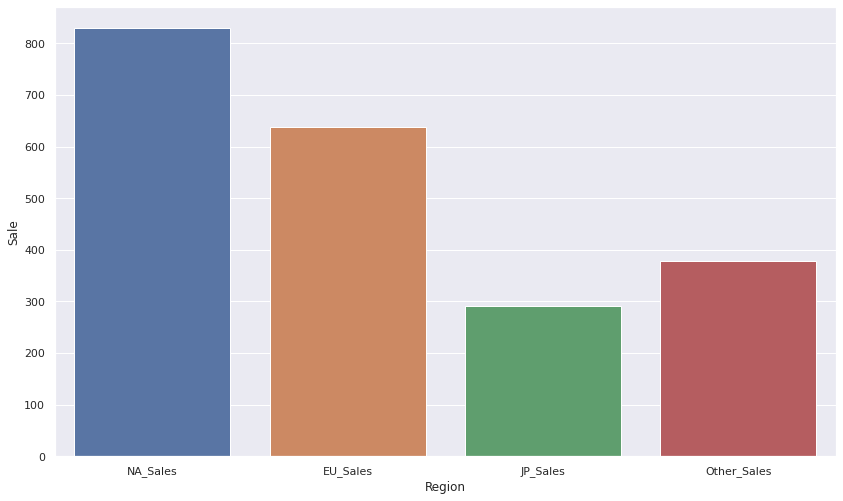

In [31]:
sns.barplot(data=fin_df_long,
            x = "Region",
            y = "Sale",
            ci = None)

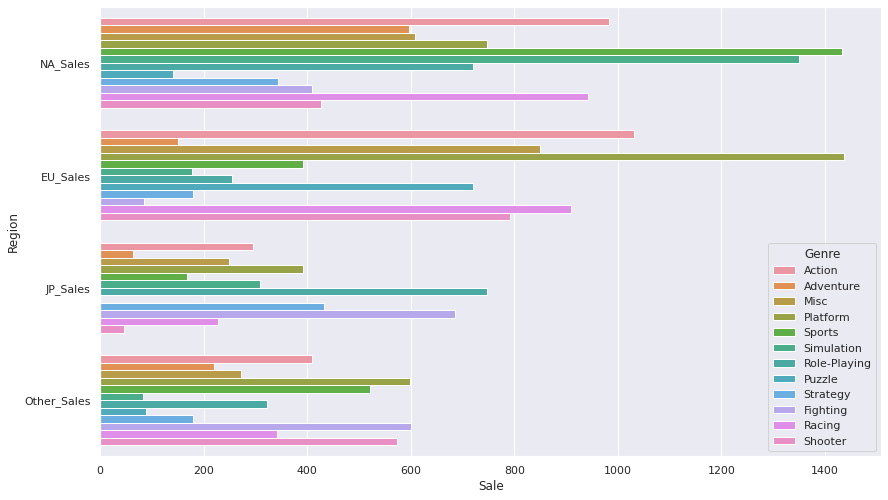

In [32]:
# 지역별 Sales 확인
sns.barplot(data=fin_df_long,
            x = "Sale",
            y = "Region",
            hue = "Genre",
            ci = None)

In [156]:
# 구체적인 숫자를 확인하기 위한 pivot table
fin_df_long.pivot_table(values='Sale', index = 'Region', columns= 'Genre')

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Region,,,,,,,,,,,,
EU_Sales,1031.27,149.30,84.15,850.18,1437.00,720.65,910.02,253.71,791.54,177.64,391.39,178.90
JP_Sales,295.96,62.88,684.38,248.00,390.95,0.10,227.50,747.31,46.58,307.77,167.73,432.26
NA_Sales,982.56,597.10,408.43,608.26,747.62,140.81,942.60,719.87,427.12,1349.32,1431.93,342.87
Other_Sales,408.84,219.97,600.28,271.59,597.76,87.90,341.25,322.17,574.16,82.88,520.26,178.85


- 지역에 따라 출고량이 달라지는지 확인하기 위해 ANOVA 시행

In [33]:
df_region = fin_df_long[['Sale','Region']]

In [34]:
aov_region = smf.ols("Sale~Region",data=df_region).fit()
print(sm.stats.anova_lm(aov_region,typ=2))

                   sum_sq       df    F  PR(>F)
Region      2962657053.75     3.00 9.72    0.00
Residual 6636190532928.58 65348.00  nan     nan


In [36]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
hsd2 = pairwise_tukeyhsd(df_region['Sale'], df_region['Region'], alpha=0.05)
hsd2.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
EU_Sales,JP_Sales,-347.7234,0.0098,-634.1655,-61.2813,True
EU_Sales,NA_Sales,190.4696,0.3194,-95.9725,476.9117,False
EU_Sales,Other_Sales,-260.2257,0.0903,-546.6678,26.2164,False
JP_Sales,NA_Sales,538.193,0.001,251.7509,824.6351,True
JP_Sales,Other_Sales,87.4977,0.8447,-198.9444,373.9398,False
NA_Sales,Other_Sales,-450.6953,0.001,-737.1374,-164.2532,True


In [79]:
df_genre = fin_df[['Total_Sales','Genre']]
aov_genre = smf.ols("Total_Sales~Genre",data=df_genre).fit()
print(sm.stats.anova_lm(aov_genre,typ=2))

                   sum_sq       df    F  PR(>F)
Genre       5839074503.69    11.00 1.31    0.21
Residual 6593496557448.00 16325.00  nan     nan



- 지역별로 선호하는 장르의 차이가 있는지  확인하기 위해 ANOVA 시행

In [37]:
df_na = fin_df[['NA_Sales','Genre']]
df_eu = fin_df[['EU_Sales','Genre']]
df_jp = fin_df[['JP_Sales','Genre']]
df_other = fin_df[['Other_Sales','Genre']]

In [38]:
aov_na = smf.ols("NA_Sales~Genre",data=df_na).fit()
aov_eu = smf.ols("EU_Sales~Genre",data=df_eu).fit()
aov_jp = smf.ols("JP_Sales~Genre",data=df_jp).fit()
aov_other = smf.ols("Other_Sales~Genre",data=df_other).fit()
print(sm.stats.anova_lm(aov_na,typ=2))
print(sm.stats.anova_lm(aov_eu,typ=2))
print(sm.stats.anova_lm(aov_jp,typ=2))
print(sm.stats.anova_lm(aov_other,typ=2))

                   sum_sq       df    F  PR(>F)
Genre       2125229718.12    11.00 1.06    0.39
Residual 2976646596941.09 16326.00  nan     nan
                   sum_sq       df    F  PR(>F)
Genre       2500987102.92    11.00 1.84    0.04
Residual 2013737638131.52 16326.00  nan     nan
                  sum_sq       df    F  PR(>F)
Genre       689934331.40    11.00 1.63    0.08
Residual 628028368810.96 16326.00  nan     nan
                   sum_sq       df    F  PR(>F)
Genre        388247408.06    11.00 0.57    0.86
Residual 1012073530484.54 16326.00  nan     nan


In [39]:
# 평균비교(사후분석)
hsd = pairwise_tukeyhsd(df_eu['EU_Sales'], df_eu['Genre'], alpha=0.05)
hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Action,Adventure,-881.9671,0.4063,-2080.7887,316.8546,False
Action,Fighting,-947.1194,0.5439,-2355.6511,461.4122,False
Action,Misc,-181.0897,0.9,-1267.3258,905.1464,False
Action,Platform,405.7311,0.9,-978.7121,1790.1742,False
Action,Puzzle,-310.6202,0.9,-1959.2393,1337.999,False
Action,Racing,-121.2536,0.9,-1334.7164,1092.2092,False
Action,Role-Playing,-777.5586,0.5271,-1920.0145,364.8972,False
Action,Shooter,-239.7269,0.9,-1433.1775,953.7236,False
Action,Simulation,-853.6259,0.6731,-2254.16,546.9082,False
Action,Sports,-639.883,0.5895,-1624.0291,344.2632,False


## 3. 연도별 트렌드

- 연도 범주형 변수 만들기
- 그림그리기

In [40]:
# 돌리는데 오래걸리니까 콜랩에서 쓰는건 추천하지 않는다. 
def year_splitter(value):
    if value < pd.to_datetime('1980-01-01'):
        return '1970s'
    elif  pd.to_datetime('1980-01-01') <= value < pd.to_datetime('1990-01-01') :
        return '1980s'
    elif pd.to_datetime('1990-01-01') <= value < pd.to_datetime('2000-01-01'):
        return '1990s'
    elif pd.to_datetime('2000-01-01') <= value < pd.to_datetime('2010-01-01'):
        return '2000s'
    elif pd.to_datetime('2010-01-01') <= value < pd.to_datetime('2020-01-01'):
        return '2010s'
    else:
        return '2020s'

In [41]:
fin_df_long['Era'] = fin_df_long['Year'].apply(year_splitter)
fin_df['Era'] = fin_df['Year'].apply(year_splitter)

In [ ]:
#plot_order = df.sort_values(by='Amount', ascending=False).ID.values

In [71]:
fin_df[fin_df.Era =='2020s']

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,Era
6907,Imagine: Makeup Artist,DS,2020-01-01,Simulation,Ubisoft,0.27,0.00,0.00,0.02,0.29,2020s
140,Saint,Wii,2021-01-01,Shooter,Unknown,20000.00,0.00,0.00,0.00,20000.00,2020s


In [48]:
e_order = fin_df.sort_values('Year').Era

In [75]:
fin_df=fin_df.sort_values('Era')

In [49]:
e_order

236      1970s
190      1970s
208      1970s
160      1970s
225      1970s
         ...  
15234    2010s
5311     2010s
10108    2010s
6907     2020s
140      2020s
Name: Era, Length: 16338, dtype: object

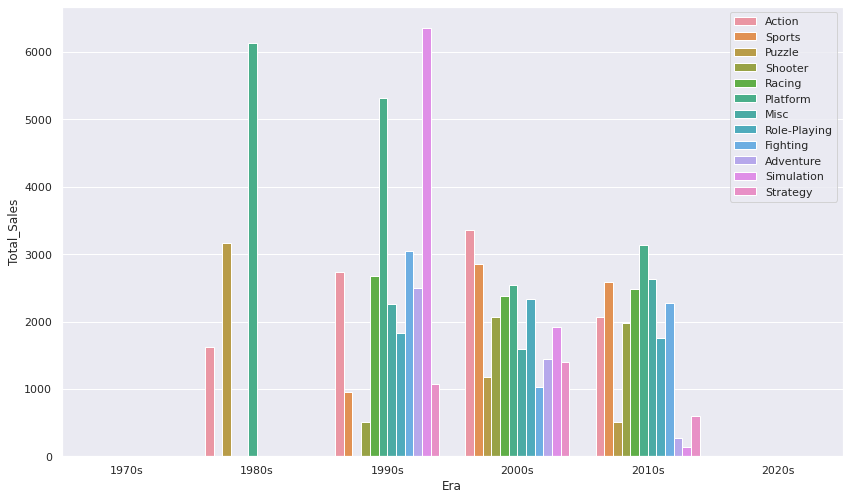

In [88]:
# 시대별 트렌드 확인
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
p3 = sns.barplot(data=fin_df,
            x = "Era",
            y = "Total_Sales",
            hue = "Genre",
            ci = None)
p3.legend(loc='upper right')

In [53]:
df_70 = fin_df[fin_df.Era=='1970s']
df_80 = fin_df[fin_df.Era=='1980s']
df_90 = fin_df[fin_df.Era=='1990s']
df_2000 = fin_df[fin_df.Era=='2000s']
df_2010 = fin_df[fin_df.Era=='2010s']
df_2020 = fin_df[fin_df.Era=='2020s']

In [55]:
aov_70 = smf.ols("Total_Sales~Genre",data=df_70).fit()
aov_80 = smf.ols("Total_Sales~Genre",data=df_80).fit()
aov_90 = smf.ols("Total_Sales~Genre",data=df_90).fit()
aov_2000 = smf.ols("Total_Sales~Genre",data=df_2000).fit()
aov_2010 = smf.ols("Total_Sales~Genre",data=df_2010).fit()
aov_2020 = smf.ols("Total_Sales~Genre",data=df_2020).fit()
print(sm.stats.anova_lm(aov_70,typ=2))
print(sm.stats.anova_lm(aov_80,typ=2))
print(sm.stats.anova_lm(aov_90,typ=2))
print(sm.stats.anova_lm(aov_2000,typ=2))
print(sm.stats.anova_lm(aov_2010,typ=2))
#print(sm.stats.anova_lm(aov_2020,typ=2))

          sum_sq   df    F  PR(>F)
Genre       0.50 4.00 0.59    0.70
Residual    0.64 3.00  nan     nan
                 sum_sq     df    F  PR(>F)
Genre      912565431.49  10.00 0.36    0.96
Residual 50269215538.23 198.00  nan     nan
                  sum_sq      df    F  PR(>F)
Genre      4299589417.53   11.00 0.95    0.49
Residual 716638157000.54 1743.00  nan     nan
                   sum_sq      df    F  PR(>F)
Genre       4822830595.08   11.00 0.99    0.45
Residual 4066386213520.51 9209.00  nan     nan
                   sum_sq      df    F  PR(>F)
Genre       3515157763.13   11.00 0.94    0.50
Residual 1751793992367.81 5131.00  nan     nan


## 4. 출고량이 높은 게임

- 출고량 top 3 게임 추출
- 해당 게임의 지역별 출고량 확인

In [57]:
fin_df.sort_values('Total_Sales',ascending = False)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales,Era
2014,LEGO Indiana Jones: The Original Adventures,PS3,2008-01-01,Action,Activision,0.44,440000.00,0.00,0.18,440000.62,2000s
3862,LEGO Batman 2: DC Super Heroes,DS,2012-01-01,Action,Warner Bros. Interactive Entertainment,430000.00,0.27,0.00,0.06,430000.33,2010s
15108,SpongeBob's Truth or Square (US sales),DS,2009-01-01,Action,THQ,420000.00,0.00,0.00,0.00,420000.00,2000s
14725,FIFA Soccer 11,X360,2010-01-01,Sports,Electronic Arts,0.71,2.40,0.02,400000.00,400003.13,2010s
10654,Ace Combat X: Skies of Deception,PSP,2006-01-01,Simulation,Namco Bandai Games,370000.00,0.31,0.12,0.19,370000.62,2000s
...,...,...,...,...,...,...,...,...,...,...,...
6411,Turok,PC,2008-01-01,Action,Touchstone,0.00,0.01,0.00,0.00,0.01,2000s
11205,The Land Before Time: Into the Mysterious Beyond,GBA,2006-01-01,Platform,Game Factory,0.01,0.00,0.00,0.00,0.01,2000s
300,Lotus Challenge,GC,2004-01-01,Racing,Ignition Entertainment,0.01,0.00,0.00,0.00,0.01,2000s
11952,Dramatical Murder Re:code,PSV,2014-01-01,Adventure,Nitroplus,0.00,0.00,0.01,0.00,0.01,2010s


In [61]:
top3 = fin_df.sort_values('Total_Sales',ascending = False).head(3)

In [63]:
top3_long = pd.melt(top3,id_vars=['Name','Platform','Year','Genre','Publisher','Total_Sales'] ,
        value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales','Other_Sales'])

In [65]:
top3_long.rename({'variable': 'Region', 'value': 'Sale'}, axis=1, inplace=True)
top3_long

,Name,Platform,Year,Genre,Publisher,Total_Sales,Region,Sale
0,LEGO Indiana Jones: The Original Adventures,PS3,2008-01-01,Action,Activision,440000.62,NA_Sales,0.44
1,LEGO Batman 2: DC Super Heroes,DS,2012-01-01,Action,Warner Bros. Interactive Entertainment,430000.33,NA_Sales,430000.00
2,SpongeBob's Truth or Square (US sales),DS,2009-01-01,Action,THQ,420000.00,NA_Sales,420000.00
3,LEGO Indiana Jones: The Original Adventures,PS3,2008-01-01,Action,Activision,440000.62,EU_Sales,440000.00
4,LEGO Batman 2: DC Super Heroes,DS,2012-01-01,Action,Warner Bros. Interactive Entertainment,430000.33,EU_Sales,0.27
5,SpongeBob's Truth or Square (US sales),DS,2009-01-01,Action,THQ,420000.00,EU_Sales,0.00
6,LEGO Indiana Jones: The Original Adventures,PS3,2008-01-01,Action,Activision,440000.62,JP_Sales,0.00
7,LEGO Batman 2: DC Super Heroes,DS,2012-01-01,Action,Warner Bros. Interactive Entertainment,430000.33,JP_Sales,0.00
8,SpongeBob's Truth or Square (US sales),DS,2009-01-01,Action,THQ,420000.00,JP_Sales,0.00
9,LEGO Indiana Jones: The Original Adventures,PS3,2008-01-01,Action,Activision,440000.62,Other_Sales,0.18


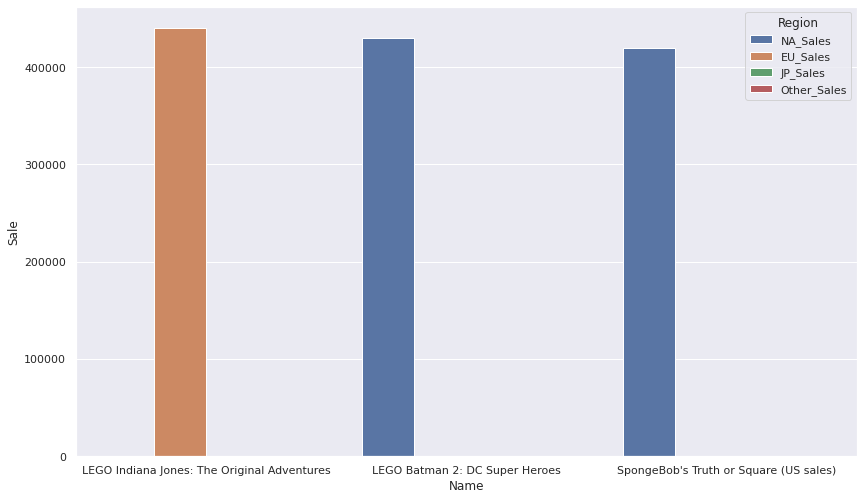

In [67]:
# 시대별 트렌드 확인
sns.barplot(data=top3_long,
            x = "Name",
            y = "Sale",
            hue = "Region",
            ci = None)

## 5. 추가사항

- 지역과 장르가 전체 출고량에 미치는 영향 확인

In [80]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

model = ols('Sale ~ Genre * Region', fin_df_long).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
Genre,11.00,1459768625.92,132706238.72,1.31,0.21
Region,3.00,2951062462.82,983687487.61,9.69,0.00
Genre:Region,33.00,4260798891.90,129115117.94,1.27,0.14
Residual,65300.00,6630101780284.93,101532952.22,nan,nan


In [70]:
fin_df.shape

(16338, 11)